In [4]:
import os
from RPA import *
import pymc as pm

path = '/Users/braden/Documents/Beam Catcher/2025 Spring Test Campaign/2025-07 Processing Folder/Varied Bias at 27 deg'
os.chdir(path)
os.getcwd()

'/Users/braden/Documents/Beam Catcher/2025 Spring Test Campaign/2025-07 Processing Folder/Varied Bias at 27 deg'

In [5]:
RPA_files = []
for file in os.listdir():
    if 'RPA' in file and 'hdf5' in file:
        RPA_files.append(file)

RPA_files

['FixedRPA_26-68deg_125V_1.hdf5',
 'FixedRPA_26-68deg_175V.hdf5',
 'FixedRPA_26-68deg_100V_1.hdf5',
 'FixedRPA_26-68deg_150V.hdf5',
 'FixedRPA_26-68deg_100V.hdf5',
 'FixedRPA_26-68deg_75V_1.hdf5',
 'FixedRPA_26-68deg_0V_1.hdf5',
 'FixedRPA_26-68deg_50V.hdf5',
 'FixedRPA_26-68deg_200V_1.hdf5',
 'FixedRPA_26-68deg_150V_1.hdf5',
 'FixedRPA_26-68deg_50V_1.hdf5',
 'FixedRPA_26-68deg_200V.hdf5',
 'FixedRPA_26-68deg_0V.hdf5',
 'FixedRPA_26-68deg_125V.hdf5',
 'FixedRPA_26-68deg_75V.hdf5',
 'FixedRPA_26-68deg_175V_1.hdf5']

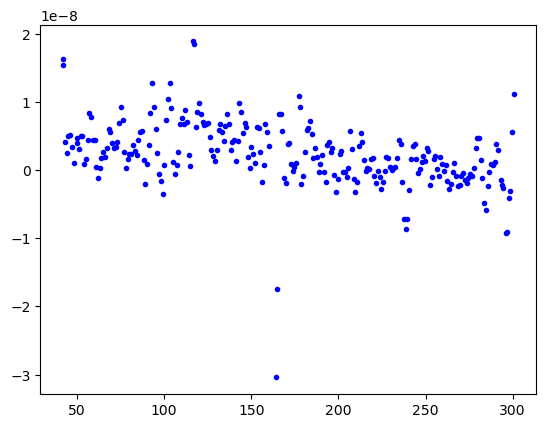

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit

with h5py.File('FixedRPA_26-68deg_150V_1.hdf5', 'r') as f:
    data = f['/Data'][:]

V_raw = data[:,1]
I_raw = data[:,2]

# --- Begin MAD outlier filter ---
window = 21  # odd, tune as needed
halfwin = window // 2

outlier_indices = []

for i in range(len(I_raw)):
    start = max(0, i - halfwin)
    end = min(len(I_raw), i + halfwin + 1)
    local_window = I_raw[start:end]
    local_median = np.median(local_window)
    local_mad = np.median(np.abs(local_window - local_median))
    if local_mad == 0:
        continue
    if np.abs(I_raw[i] - local_median) > 5 * local_mad:
        outlier_indices.append(i)

# Now create cleaned data arrays, omitting outliers
outlier_indices = np.array(outlier_indices)
keep_indices = np.setdiff1d(np.arange(len(I_raw)), outlier_indices)

V_clean = V_raw[keep_indices]
I_clean = I_raw[keep_indices]
# --- End MAD outlier filter ---

# Remove *duplicate* voltages (keeping the first instance)
_, unique_indices = np.unique(V_clean, return_index=True)
V = V_clean[sorted(unique_indices)]
I = I_clean[sorted(unique_indices)]

I_smooth = savgol_filter(I, window_length=11, polyorder=5)

plt.figure()
dIdV = -np.gradient(I_smooth, V)
dIdV_raw = -np.gradient(I, V)
plt.plot(V[40:], dIdV[40:], 'b.')
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, x0, sigma, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.



Parameter means (scaled back to data units):
a (amplitude):   8.29e-08
x0 (MPV):        28.56 V (95% CI: 27.07 to 29.98 V)
sigma (width):  4.06 V
c (baseline):   1.23e-08


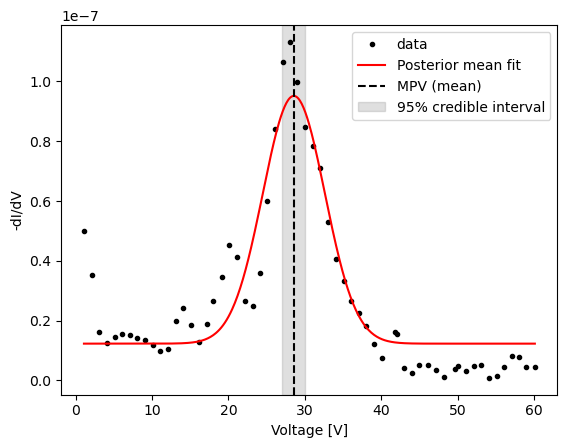

In [23]:
# Separate by high energy population and low energy population
V_lim = 60

V_high = V[V_lim:150]
dIdV_high = dIdV[V_lim:150]

V_low = V[:V_lim]
dIdV_low = dIdV[:V_lim]

# x: your V_high (or any window)
# y: your dIdV_high (same for low-energy)
x = V_low
y = dIdV_low

# 1. Scale x and y for numerically stable inference ---------------------------
xmean, xstd = np.mean(x), np.std(x)
ymean, ystd = np.mean(y), np.std(y) if np.std(y) != 0 else 1.0

x_scaled = (x - xmean) / xstd
y_scaled = (y - ymean) / ystd

# 2. Estimate noise for likelihood term ---------------------------------------
# If unknown, just use empirical std:
yerr = np.std(y_scaled) if np.std(y_scaled) != 0 else 1.0
yerr_array = np.full_like(y_scaled, yerr)

# 3. PyMC Bayesian Gaussian Fit -----------------------------------------------
with pm.Model() as model:
    # Scaled priors
    a = pm.HalfNormal('a', sigma=np.max(y_scaled) or 1.0)
    x0 = pm.Uniform('x0', lower=min(x_scaled), upper=max(x_scaled))
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    c = pm.Normal('c', mu=np.median(y_scaled), sigma=2*np.abs(np.median(y_scaled)) + 1e-12)

    # Gaussian model
    mu = a * pm.math.exp(-(x_scaled - x0) ** 2 / (2 * sigma ** 2)) + c

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=yerr, observed=y_scaled)
    
    # MCMC sampling
    trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.99, progressbar=True, random_seed=42)

# 4. Extract mean and credible intervals (unscale!) ---------------------------
a_mean = np.mean(trace.posterior['a'].values)
x0_mean_scaled = np.mean(trace.posterior['x0'].values)
sigma_mean_scaled = np.mean(trace.posterior['sigma'].values)
c_mean = np.mean(trace.posterior['c'].values)

# For 95% credible interval
x0_samples_scaled = trace.posterior['x0'].values.flatten()
x0_lower_scaled, x0_upper_scaled = np.percentile(x0_samples_scaled, [2.5, 97.5])

# Unscale back to your input units:
x0_mean = x0_mean_scaled * xstd + xmean
x0_lower = x0_lower_scaled * xstd + xmean
x0_upper = x0_upper_scaled * xstd + xmean

print(f"\nParameter means (scaled back to data units):")
print(f"a (amplitude):   {a_mean * ystd:.3g}")
print(f"x0 (MPV):        {x0_mean:.2f} V (95% CI: {x0_lower:.2f} to {x0_upper:.2f} V)")
print(f"sigma (width):  {sigma_mean_scaled * xstd:.2f} V")
print(f"c (baseline):   {c_mean * ystd + ymean:.3g}")

# 5. Plot posterior mean fit in original units --------------------------------
def gaussian_model(x, a, x0, sigma, c):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + c

xfit = np.linspace(x.min(), x.max(), 500)
yfit = gaussian_model(xfit, a_mean * ystd, x0_mean, sigma_mean_scaled * xstd, c_mean * ystd + ymean)

plt.figure()
plt.plot(x, y, 'k.', label='data')
plt.plot(xfit, yfit, 'r-', label='Posterior mean fit')
plt.axvline(x0_mean, color='k', linestyle='--', label='MPV (mean)')
plt.axvspan(x0_lower, x0_upper, color='gray', alpha=0.25, label='95% credible interval')
plt.xlabel('Voltage [V]')
plt.ylabel('-dI/dV')
plt.legend()
plt.show()


Parameter means (scaled back to data units):
a (amplitude):   5.64e-09
x0 (MPV):        115.32 V (95% CI: 55.36 to 130.53 V)
sigma (width):  10.73 V
c (baseline):   3.6e-09


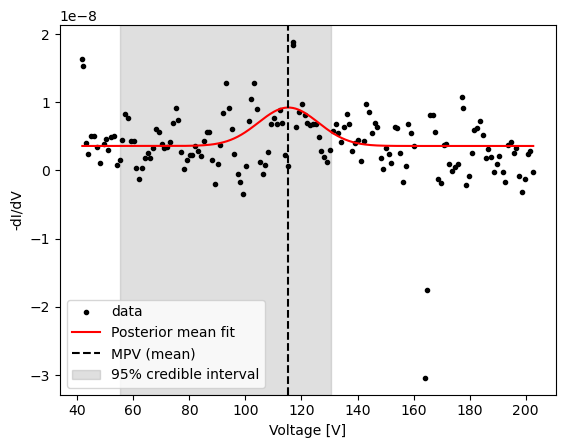

In [17]:
# For 95% credible interval
x0_samples_scaled = trace.posterior['x0'].values.flatten()
x0_lower_scaled, x0_upper_scaled = np.percentile(x0_samples_scaled, [2.5, 97.5])

# Unscale back to your input units:
x0_mean = x0_mean_scaled * xstd + xmean
x0_lower = x0_lower_scaled * xstd + xmean
x0_upper = x0_upper_scaled * xstd + xmean

print(f"\nParameter means (scaled back to data units):")
print(f"a (amplitude):   {a_mean * ystd:.3g}")
print(f"x0 (MPV):        {x0_mean:.2f} V (95% CI: {x0_lower:.2f} to {x0_upper:.2f} V)")
print(f"sigma (width):  {sigma_mean_scaled * xstd:.2f} V")
print(f"c (baseline):   {c_mean * ystd + ymean:.3g}")

# 5. Plot posterior mean fit in original units --------------------------------
def gaussian_model(x, a, x0, sigma, c):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + c

xfit = np.linspace(x.min(), x.max(), 500)
yfit = gaussian_model(xfit, a_mean * ystd, x0_mean, sigma_mean_scaled * xstd, c_mean * ystd + ymean)

plt.figure()
plt.plot(x, y, 'k.', label='data')
plt.plot(xfit, yfit, 'r-', label='Posterior mean fit')
plt.axvline(x0_mean, color='k', linestyle='--', label='MPV (mean)')
plt.axvspan(x0_lower, x0_upper, color='gray', alpha=0.25, label='95% credible interval')
plt.xlabel('Voltage [V]')
plt.ylabel('-dI/dV')
plt.legend()
plt.show()

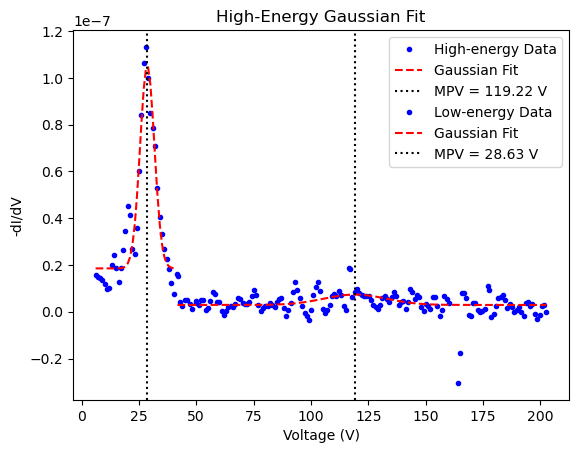

In [97]:
plt.figure()
plt.plot(V_high, dIdV_high, 'b.', label='High-energy Data')
plt.plot(V_high, gaussian(V_high, *popt_high), 'r--', label='Gaussian Fit')
plt.axvline(mpv_high, c='k', ls=':', label=f'MPV = {mpv_high:.2f} V')
plt.plot(V_low, dIdV_low, 'b.', label='Low-energy Data')
plt.plot(V_low, gaussian(V_low, *popt_low), 'r--', label='Gaussian Fit')
plt.axvline(mpv_low, c='k', ls=':', label=f'MPV = {mpv_low:.2f} V')
plt.legend()
plt.title("High-Energy Gaussian Fit")
plt.xlabel("Voltage (V)")
plt.ylabel("-dI/dV")
plt.show()

In [3]:
extract_MPV('FixedRPA_26-68deg_150V_1.hdf5')

(98.33594257846312, 10.276267750961225, 28.6338062617779, 0.19588643917902612)